In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import *
import h5py
import scipy.stats as sts

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.syndat.MMDA import generate
from ATARI.theory.xs import SLBW
from ATARI.theory.scattering_params import FofE_recursive
from ATARI.theory.scattering_params import gstat
from ATARI.utils.datacontainer import DataContainer
from ATARI.utils.atario import fill_resonance_ladder

from numpy.linalg import inv
from scipy.linalg import block_diag

from scipy.optimize import lsq_linear
from qpsolvers import solve_qp
from scipy.optimize import linprog

import functions as fn 


In [2]:
%matplotlib widget

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


<ErrorbarContainer object of 3 artists>

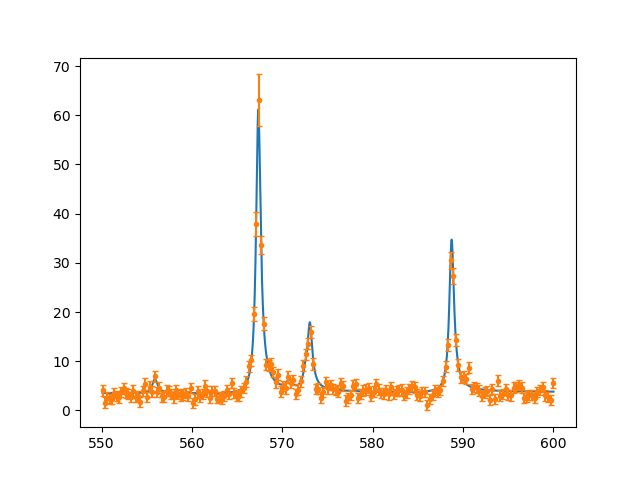

In [3]:

ac = 0.81271  # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider


Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={})



spin_groups = [ (3.0,1,0)] # , (4.0,1,[0]) ]
average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':8.79, '4.0':4.99},
                                    'Gg'    :   {'3.0':640.0, '4.0':64.0},
                                    'gn2'    :   {'3.0':46.4, '4.0':35.5}  })


E_min_max = [550, 600]
energy_grid = E_min_max

input_options = {'Add Noise': True,
                'Calculate Covariance': True,
                'Compression Points':[],
                'Grouping Factors':None}

experiment_parameters = {'bw': {'val':0.0256,    'unc'   :   0}}

# initialize experimental setup
exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)


resonance_ladder = Ta_pair.sample_resonance_ladder(E_min_max, spin_groups, average_parameters, False)
# resonance_ladder = pd.DataFrame({'E':[570], 'J':[3.0], 'chs':[1.0], 'lwave':[0.0], 'J_ID':[1.0], 'gnx2':[100], 'Gg':[750]})
# resonance_ladder = pd.DataFrame({'E':[575], 'J':[3.0], 'chs':[1.0], 'lwave':[0.0], 'J_ID':[1.0], 'gnx2':[5000], 'Gg':[75]})
true, _, _ = SLBW(exp.energy_domain, Ta_pair, resonance_ladder)
df_true = pd.DataFrame({'E':exp.energy_domain, 'theo_trans':np.exp(-exp.redpar.val.n*true)})

exp.run(df_true)

from ATARI.utils.datacontainer import DataContainer
from ATARI.theory.experimental import trans_2_xs

dc = DataContainer()
dc.add_theoretical(Ta_pair, resonance_ladder)
threshold_0T = 1e-2
dc.add_experimental(exp, threshold=threshold_0T)

max_xs, _ = trans_2_xs(threshold_0T, dc.n)

figure()
plot(dc.pw_fine.E, dc.pw_fine.theo_xs)
errorbar(dc.pw_exp.E, dc.pw_exp.exp_xs, yerr=dc.pw_exp.exp_xs_unc, fmt='.', capsize=2)
# ylim([-5, max_xs*1.25])


In [4]:
average_parameters.loc[:,['Gn']] = average_parameters['gn2']/12.5
Elam_features, Gtot_features = fn.get_parameter_grid(energy_grid, average_parameters, '3.0', 1e-1, 1e-2)
Gtot_features = [0.755, 0.758, 0.760]

# get resonance feature matrix
Resonance_Matrix, potential_scattering = fn.get_resonance_feature_bank(dc.pw_exp.E, dc.particle_pair, Elam_features, Gtot_features)
nfeatures = np.shape(Resonance_Matrix)[1]
print(nfeatures)

def get_0Trans_constraint(A, max_xs, index_0Trans):
    constraint = - np.array([max_xs]*len(index_0Trans))
    constraint_mat = -A.copy()[index_0Trans, :]
    return constraint_mat, constraint

def remove_nan_values(full_xs, full_cov, full_pscat, full_feature_matrix):
    index_0T = np.argwhere(np.isnan(full_xs)).flatten()
    index_finiteT = np.argwhere(np.isfinite(full_xs)).flatten()

    cov = full_cov.copy()[index_finiteT, :]
    cov = cov[:, index_finiteT]

    xs = full_xs[index_finiteT]
    pscat = full_pscat[index_finiteT]

    feature_matrix = full_feature_matrix[index_finiteT, :]

    return xs, cov, pscat, feature_matrix, index_0T


# remove nan values in xs and cov for solver
b, cov, pscat, A, index_0T = remove_nan_values(np.array(dc.pw_exp.exp_xs), np.array(dc.CovXS), potential_scattering.flatten(), Resonance_Matrix)
b = b-pscat

# get bounds and constraints
lb, ub = fn.get_bound_arrays(nfeatures, 0, 1)
G, h = get_0Trans_constraint(Resonance_Matrix, max_xs, index_0T)
# G, h = fn.get_0Trans_constraint(Resonance_Matrix, max_xs, index_0T, dc.pw_exp.E)

# Cast into quadratic program 
P = A.T @ inv(cov) @ A
q = - A.T @ inv(cov) @ b

# solve linear program
# lp_res = linprog(q, A_ub=G, b_ub=h, bounds=np.array([lb, ub]).T)

# solve quadratic program
qp_res = solve_qp(P, q, G=G, h=h, A=None, b=None, lb=lb, ub=ub, 
                                                            solver="cvxopt",
                                                            verbose=False,
                                                            abstol=1e-12,
                                                            reltol=1e-12,
                                                            feastol= 1e-8,
                                                            maxiters = 100)

1506


### Now perform bisection method to find a weight constraint that will give 5 resonances above weight threshold

Can estimate the minimum number of iterations required to find the root:




In [5]:
len(P)

1506

In [6]:
def solve_qp_w_constraint(P, q, G, h, w_constraint, w_threshold=1e-10):
    G_wc = np.vstack([G,np.ones(len(P))])
    h_wc = np.append(h, w_constraint)
    qp_res_c = solve_qp(P, q, G=G_wc, h=h_wc, A=None, b=None, lb=lb, ub=ub, 
                                                        solver="cvxopt",
                                                        verbose=False,
                                                        abstol=1e-12,
                                                        reltol=1e-12,
                                                        feastol= 1e-8,
                                                        maxiters = 100) 
    return qp_res_c, np.count_nonzero(qp_res_c>w_threshold)

def secant_method(f, x0, y0, x1, offset, tol=1e-5, n=0):
    # increment counter
    n += 1

    # calculate weights and number of resonances at endpoints
    qp_res, numres = f(x1)
    y1 = numres-offset

    # calculate next root approximation
    xn = x1 - y1 * ((x1 - x0) / (y1 - y0))
    # if nan or inf (bc same y val) divide by non-zero  #TODO: find the best normalization here, 1 works but maybe something else is faster?
    # if np.isnan(xn) or np.isinf(xn):
    #     xn = x1 - y1 * ((x1 - x0) /1)

    # check tolerance condition - could do list comprehension here to get w_constraints corrresponding to multiple different resonances in one go
    if -tol < y1 < tol:
        return xn, n, qp_res
    
    # recursive call with updated interval
    return secant_method(f, x1, y1, xn, offset, tol=tol, n=n)


In [8]:
# iw_keep = np.argwhere(qp_res>w_threshold).flatten()
# new_full_feature_matrix = full_feature_matrix[:, iw_keep]
# y0, y1 = number_of_surviving_resonances(P, q, G, h, 0, w_threshold), number_of_surviving_resonances(P, q, G, h, np.sum(qp_res), w_threshold)

full_feature_matrix = Resonance_Matrix
w_threshold = 1e-10
def func(w):
    return solve_qp_w_constraint(P, q, G, h, w, w_threshold)

w_constraint, niter, qp_res = secant_method(func, 0, -5, np.sum(qp_res), 5, tol=1e-2, n=0)

In [10]:
np.count_nonzero(qp_res>w_threshold)

5

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


(-5.0, 102.84601255072708)

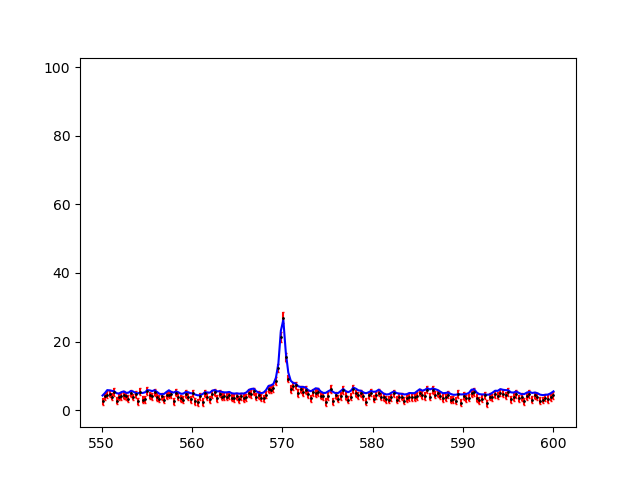

In [ ]:
figure()
errorbar(dc.pw_exp.E, dc.pw_exp.exp_xs, yerr=np.sqrt(np.diag(dc.CovXS)), fmt='.', ecolor='r', color='k', capsize=1, ms=2)
# plot(dc.pw_exp.E, Resonance_Matrix@lp_res.x+potential_scattering.flatten(), lw=2, color='purple')
plot(dc.pw_exp.E, Resonance_Matrix@qp_res+potential_scattering.flatten(), color='blue')

ylim([-5, max_xs*1.5])